In [1]:
import pandas as pd
import numpy as np
import itertools
import lightgbm as lgbm
import matplotlib.pyplot as plt

from script import *
from feature_engineering import *
import db_operations as dbop
from constants import *
import data_process as dp

import time

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
pd.set_option('display.max_rows',200)
idx = pd.IndexSlice
agg_operations =['mean','median','max','min','std','size']

In [8]:
# %time df = pd.read_hdf(os.path.join('datasets','df_20140101.h5'),key='data')
df = df.sort_index()
df.shape
df.columns

(4593560, 64)

Index(['open', 'high', 'low', 'close', 'vol', 'amt', 'adj_factor', 'avg',
       'close0', 'avg0', 'pct', 'turnover_rate', 'turnover_rate_f',
       'volume_ratio', 'pe', 'pe_ttm', 'pb', 'ps', 'ps_ttm', 'total_share',
       'float_share', 'free_share', 'total_mv', 'circ_mv', 'pb*pe_ttm',
       'pb*pe', '5ma', '10ma', '20ma', '40ma', '60ma', '120ma', '250ma',
       'close/5ma', 'close/10ma', 'close/20ma', 'close/40ma', 'close/60ma',
       'close/120ma', 'close/250ma', '60ma_pct', '20ma_pct', 'p5max_abs_pct',
       'p10max_abs_pct', '30ma', '30ma_pct', 'close/30ma', 'prev_close',
       'day_pct', 'close0_rank', 'close0_pct', 'prev_pct', 'prev_day_pct',
       'sell_at', 'sell_at0', 'sell_date', 'sell_idx', 'buy_at', 'buy_at0',
       'max', 'max_idx', 'idx', 'is_selled', 'r'],
      dtype='object')

In [9]:
df['track0'] = (df['open']/df['prev_close']-1)*100
df[['prev_close','open','close','track0']].head()

prev_close        open       close    track0
code      date                                                    
000001.SZ 2014-01-02         NaN  707.650452  714.072998       NaN
          2014-01-03  714.072998  709.402039  696.556946 -0.654131
          2014-01-06  696.556946  694.221436  681.376282 -0.335294
          2014-01-07  681.376282  673.202087  679.040833 -1.199657
          2014-01-08  679.040833  679.624695  686.631165  0.085986

In [10]:
mask = df['close']>df['open']
df.loc[mask,'track1']=(df.loc[mask,'low']/df.loc[mask,'open']-1)*100
df.loc[mask,'track2']=(df.loc[mask,'high']/df.loc[mask,'low']-1)*100
df.loc[mask,'track3']=(df.loc[mask,'close']/df.loc[mask,'high']-1)*100

df.loc[~mask,'track1']=(df.loc[~mask,'high']/df.loc[~mask,'open']-1)*100
df.loc[~mask,'track2']=(df.loc[~mask,'low']/df.loc[~mask,'high']-1)*100
df.loc[~mask,'track3']=(df.loc[~mask,'close']/df.loc[~mask,'low']-1)*100


In [11]:
df[['prev_close','open','low','high','close','track0','track1','track2','track3']].head(10)
df[['prev_close','open','low','high','close','track0','track1','track2','track3']].tail(10)

prev_close        open         low        high  \
code      date                                                         
000001.SZ 2014-01-02         NaN  707.650452  703.563354  718.160095   
          2014-01-03  714.072998  709.402039  687.798828  709.985901   
          2014-01-06  696.556946  694.221436  671.450500  700.644043   
          2014-01-07  681.376282  673.202087  672.034424  686.631165   
          2014-01-08  679.040833  679.624695  673.202087  697.724670   
          2014-01-09  686.631165  682.544006  680.208557  700.060120   
          2014-01-10  690.134338  687.798828  680.792419  697.724670   
          2014-01-13  690.134338  688.966614  670.866638  695.389160   
          2014-01-14  677.289246  675.537598  668.531128  687.798828   
          2014-01-15  684.295654  683.127930  674.953735  685.463379   

                           close    track0    track1    track2    track3  
code      date                                                            
000001.SZ 2014-01-02  714.072998       NaN -0.577557  2.074683 -0.569105  
          2014-01-03  696.556946 -0.654131  0.082302 -3.125000  1.273358  
          2014-01-06  681.376282 -0.335294  0.925148 -4.166675  1.478255  
          2014-01-07  679.040833 -1.199657 -0.173450  2.172017 -1.105446  
          2014-01-08  686.631165  0.085986 -0.945020  3.642678 -1.589954  
          2014-01-09  690.134338 -0.595248 -0.342166  2.918458 -1.417845  
          2014-01-10  690.134338 -0.338411 -1.018673  2.487135 -1.087868  
          2014-01-13  677.289246 -0.169200  0.932205 -3.526443  0.957358  
          2014-01-14  684.295654 -0.258625 -1.037169  2.882099 -0.509334  
          2014-01-15  681.376282 -0.170648  0.341880 -1.533216  0.951552

prev_close        open        low        high  \
code      date                                                        
688598.SH 2020-05-18         NaN  110.000000  90.879997  111.900002   
          2020-05-19   90.930000   90.300003  86.000000   97.500000   
          2020-05-20   96.150002   95.699997  89.900002  104.000000   
          2020-05-21   92.150002   90.300003  86.500000   91.980003   
          2020-05-22   87.000000   87.879997  86.519997   92.379997   
          2020-05-25   88.000000   88.669998  76.720001   88.669998   
          2020-05-26   78.300003   78.470001  77.510002   81.500000   
          2020-05-27   79.580002   82.040001  82.040001   93.150002   
          2020-05-28   90.300003   93.059998  86.379997   94.970001   
          2020-05-29   92.360001   88.000000  87.000000   91.330002   

                          close    track0    track1     track2    track3  
code      date                                                            
688598.SH 2020-05-18  90.930000       NaN  1.727271 -18.784630  0.055015  
          2020-05-19  96.150002 -0.692838 -4.761910  13.372087 -1.384616  
          2020-05-20  92.150002 -0.468022  8.672941 -13.557691  2.502775  
          2020-05-21  87.000000 -2.007592  1.860464  -5.957818  0.578034  
          2020-05-22  88.000000  1.011491 -1.547563   6.773007 -4.741282  
          2020-05-25  78.300003  0.761366  0.000000 -13.476933  2.059436  
          2020-05-26  79.580002  0.217116 -1.223397   5.147719 -2.355826  
          2020-05-27  90.300003  3.091228  0.000000  13.542175 -3.059578  
          2020-05-28  92.360001  3.056467  2.052438  -9.044963  6.922901  
          2020-05-29  88.099998 -4.720658 -1.136363   4.977012 -3.536630

In [116]:
w = [0.7,0.8,0.9,1]
# w = [0.4,0.6,0.8,1]
df['track_len'] = df['track0'].abs()*w[0]+df['track1'].abs()*w[1]+df['track2'].abs()*w[2]+df['track3'].abs()*w[3]
df['unit_amt'] = df['amt']/df['track_len']
for i in range(4):
    %time df['track{}_pa'.format(i)] = df['track{}'.format(i)] * df['track{}'.format(i)].abs() *w[i]*df['unit_amt']
#     df[['track0_pa','track1_pa','track2_pa','track3_pa']] = (df[['track0','track1','track2','track3']]*df['unit_amt']).values


Wall time: 87.9 ms
Wall time: 102 ms
Wall time: 122 ms
Wall time: 115 ms


In [16]:
df[['prev_close','open','low','high','close','track0','track1','track2','track3','track_len','unit_amt','amt']].head(10)


prev_close        open         low        high  \
code      date                                                         
000001.SZ 2014-01-02         NaN  707.650452  703.563354  718.160095   
          2014-01-03  714.072998  709.402039  687.798828  709.985901   
          2014-01-06  696.556946  694.221436  671.450500  700.644043   
          2014-01-07  681.376282  673.202087  672.034424  686.631165   
          2014-01-08  679.040833  679.624695  673.202087  697.724670   
          2014-01-09  686.631165  682.544006  680.208557  700.060120   
          2014-01-10  690.134338  687.798828  680.792419  697.724670   
          2014-01-13  690.134338  688.966614  670.866638  695.389160   
          2014-01-14  677.289246  675.537598  668.531128  687.798828   
          2014-01-15  684.295654  683.127930  674.953735  685.463379   

                           close    track0    track1    track2    track3  \
code      date                                                             
000001.SZ 2014-01-02  714.072998       NaN -0.577557  2.074683 -0.569105   
          2014-01-03  696.556946 -0.654131  0.082302 -3.125000  1.273358   
          2014-01-06  681.376282 -0.335294  0.925148 -4.166675  1.478255   
          2014-01-07  679.040833 -1.199657 -0.173450  2.172017 -1.105446   
          2014-01-08  686.631165  0.085986 -0.945020  3.642678 -1.589954   
          2014-01-09  690.134338 -0.595248 -0.342166  2.918458 -1.417845   
          2014-01-10  690.134338 -0.338411 -1.018673  2.487135 -1.087868   
          2014-01-13  677.289246 -0.169200  0.932205 -3.526443  0.957358   
          2014-01-14  684.295654 -0.258625 -1.037169  2.882099 -0.509334   
          2014-01-15  681.376282 -0.170648  0.341880 -1.533216  0.951552   

                      track_len  unit_amt       amt  
code      date                                       
000001.SZ 2014-01-02        NaN       NaN  5.962237  
          2014-01-03   4.609591  1.424489  6.566313  
          2014-01-06   6.203086  1.095068  6.792804  
          2014-01-07   4.038780  0.975487  3.939776  
          2014-01-08   5.684570  0.947189  5.384362  
          2014-01-09   4.734864  1.218347  5.768706  
          2014-01-10   4.378116  1.028953  4.504877  
          2014-01-13   4.995360  1.119789  5.593752  
          2014-01-14   4.113995  1.022644  4.207152  
          2014-01-15   2.724405  1.272693  3.467330

In [117]:
df.loc[mask,'lw_pa'] = df.loc[mask,'track2_pa']
df.loc[mask,'sw_pa'] = df.loc[mask,['track1_pa','track3_pa']].sum(axis=1)

df.loc[~mask,'sw_pa'] = df.loc[~mask,'track2_pa']
df.loc[~mask,'lw_pa'] = df.loc[~mask,['track1_pa','track3_pa']].sum(axis=1)

df[['prev_close','open','low','high','close','track0','track1','track2','track3','track_len','unit_amt','amt','lw_pa','sw_pa']].head(10)


prev_close        open         low        high  \
code      date                                                         
000001.SZ 2014-01-02         NaN  707.650452  703.563354  718.160095   
          2014-01-03  714.072998  709.402039  687.798828  709.985901   
          2014-01-06  696.556946  694.221436  671.450500  700.644043   
          2014-01-07  681.376282  673.202087  672.034424  686.631165   
          2014-01-08  679.040833  679.624695  673.202087  697.724670   
          2014-01-09  686.631165  682.544006  680.208557  700.060120   
          2014-01-10  690.134338  687.798828  680.792419  697.724670   
          2014-01-13  690.134338  688.966614  670.866638  695.389160   
          2014-01-14  677.289246  675.537598  668.531128  687.798828   
          2014-01-15  684.295654  683.127930  674.953735  685.463379   

                           close    track0    track1    track2    track3  \
code      date                                                             
000001.SZ 2014-01-02  714.072998       NaN -0.577557  2.074683 -0.569105   
          2014-01-03  696.556946 -0.654131  0.082302 -3.125000  1.273358   
          2014-01-06  681.376282 -0.335294  0.925148 -4.166675  1.478255   
          2014-01-07  679.040833 -1.199657 -0.173450  2.172017 -1.105446   
          2014-01-08  686.631165  0.085986 -0.945020  3.642678 -1.589954   
          2014-01-09  690.134338 -0.595248 -0.342166  2.918458 -1.417845   
          2014-01-10  690.134338 -0.338411 -1.018673  2.487135 -1.087868   
          2014-01-13  677.289246 -0.169200  0.932205 -3.526443  0.957358   
          2014-01-14  684.295654 -0.258625 -1.037169  2.882099 -0.509334   
          2014-01-15  681.376282 -0.170648  0.341880 -1.533216  0.951552   

                      track_len  unit_amt       amt      lw_pa      sw_pa  
code      date                                                             
000001.SZ 2014-01-02        NaN       NaN  5.962237        NaN   0.000000  
          2014-01-03   4.609591  1.424489  6.566313   2.317443 -12.519925  
          2014-01-06   6.203086  1.095068  6.792804   3.142798 -17.110510  
          2014-01-07   4.038780  0.975487  3.939776   4.141811  -1.215532  
          2014-01-08   5.684570  0.947189  5.384362  11.311514  -3.071168  
          2014-01-09   4.734864  1.218347  5.768706   9.339428  -2.563338  
          2014-01-10   4.378116  1.028953  4.504877   5.728447  -2.071914  
          2014-01-13   4.995360  1.119789  5.593752   1.804808 -12.532932  
          2014-01-14   4.113995  1.022644  4.207152   7.645129  -1.145357  
          2014-01-15   2.724405  1.272693  3.467330   1.271366  -2.692606

In [118]:
mask_gap = df['open']>df['prev_close']
# df.loc[mask_gap,'track0_pa'].head(10)
# df.loc[~mask_gap,'track0_pa'].head(10)
df.loc[mask_gap,'lw_pa'] += df.loc[mask_gap,'track0_pa']
df.loc[~mask_gap,'sw_pa'] += df.loc[~mask_gap,'track0_pa']

df[['prev_close','open','low','high','close','track0','track1','track2','track3','track_len','unit_amt','amt','lw_pa','sw_pa']].head(10)


prev_close        open         low        high  \
code      date                                                         
000001.SZ 2014-01-02         NaN  707.650452  703.563354  718.160095   
          2014-01-03  714.072998  709.402039  687.798828  709.985901   
          2014-01-06  696.556946  694.221436  671.450500  700.644043   
          2014-01-07  681.376282  673.202087  672.034424  686.631165   
          2014-01-08  679.040833  679.624695  673.202087  697.724670   
          2014-01-09  686.631165  682.544006  680.208557  700.060120   
          2014-01-10  690.134338  687.798828  680.792419  697.724670   
          2014-01-13  690.134338  688.966614  670.866638  695.389160   
          2014-01-14  677.289246  675.537598  668.531128  687.798828   
          2014-01-15  684.295654  683.127930  674.953735  685.463379   

                           close    track0    track1    track2    track3  \
code      date                                                             
000001.SZ 2014-01-02  714.072998       NaN -0.577557  2.074683 -0.569105   
          2014-01-03  696.556946 -0.654131  0.082302 -3.125000  1.273358   
          2014-01-06  681.376282 -0.335294  0.925148 -4.166675  1.478255   
          2014-01-07  679.040833 -1.199657 -0.173450  2.172017 -1.105446   
          2014-01-08  686.631165  0.085986 -0.945020  3.642678 -1.589954   
          2014-01-09  690.134338 -0.595248 -0.342166  2.918458 -1.417845   
          2014-01-10  690.134338 -0.338411 -1.018673  2.487135 -1.087868   
          2014-01-13  677.289246 -0.169200  0.932205 -3.526443  0.957358   
          2014-01-14  684.295654 -0.258625 -1.037169  2.882099 -0.509334   
          2014-01-15  681.376282 -0.170648  0.341880 -1.533216  0.951552   

                      track_len  unit_amt       amt      lw_pa      sw_pa  
code      date                                                             
000001.SZ 2014-01-02        NaN       NaN  5.962237        NaN        NaN  
          2014-01-03   4.609591  1.424489  6.566313   2.317443 -12.946590  
          2014-01-06   6.203086  1.095068  6.792804   3.142798 -17.196687  
          2014-01-07   4.038780  0.975487  3.939776   4.141811  -2.198260  
          2014-01-08   5.684570  0.947189  5.384362  11.316416  -3.071168  
          2014-01-09   4.734864  1.218347  5.768706   9.339428  -2.865517  
          2014-01-10   4.378116  1.028953  4.504877   5.728447  -2.154401  
          2014-01-13   4.995360  1.119789  5.593752   1.804808 -12.555373  
          2014-01-14   4.113995  1.022644  4.207152   7.645129  -1.193238  
          2014-01-15   2.724405  1.272693  3.467330   1.271366  -2.718549

In [119]:
min_periods=1
%time df[['p20sum_lw_pa','p20sum_sw_pa','p20sum_amt','p20sum_track_len']] = groupby_rolling(df[['lw_pa','sw_pa','amt','track_len']],level="code",window=20,ops=['sum'],min_periods=min_periods) # 7s


Wall time: 9.85 s


In [42]:
df[['track0','track1','track2','track3','track_len','unit_amt','amt','lw_pa','sw_pa','p20sum_lw_pa','p20sum_sw_pa','p20sum_amt','p20sum_track_len']].head(100)

track0    track1    track2    track3  track_len  \
code      date                                                            
000001.SZ 2014-01-02       NaN -0.577557  2.074683 -0.569105        NaN   
          2014-01-03 -0.654131  0.082302 -3.125000  1.273358   4.609591   
          2014-01-06 -0.335294  0.925148 -4.166675  1.478255   6.203086   
          2014-01-07 -1.199657 -0.173450  2.172017 -1.105446   4.038780   
          2014-01-08  0.085986 -0.945020  3.642678 -1.589954   5.684570   
          2014-01-09 -0.595248 -0.342166  2.918458 -1.417845   4.734864   
          2014-01-10 -0.338411 -1.018673  2.487135 -1.087868   4.378116   
          2014-01-13 -0.169200  0.932205 -3.526443  0.957358   4.995360   
          2014-01-14 -0.258625 -1.037169  2.882099 -0.509334   4.113995   
          2014-01-15 -0.170648  0.341880 -1.533216  0.951552   2.724405   
          2014-01-16 -0.085688 -0.686109  1.899827 -0.932211   3.250923   
          2014-01-17 -0.598794  0.172114 -1.632309  0.262010   2.287936   
          2014-01-20  0.000000  0.000000 -2.003479  0.444448   2.247579   
          2014-01-21  0.176990  0.000000  2.120137 -1.730108   3.762125   
          2014-01-22  0.000000 -0.088018  4.493380 -0.590211   4.704667   
          2014-01-23 -0.169635  0.169921 -1.187450  0.429189   1.752575   
          2014-01-24 -0.512820 -0.601375  2.074337 -1.270121   3.977099   
          2014-01-27 -0.857633  0.605536 -2.407563  0.352418   3.603997   
          2014-01-28  0.526774 -0.698692  1.934922 -0.776529   3.445654   
          2014-01-29  0.347829 -0.346625  1.217389 -0.687283   2.303714   
          2014-01-30 -0.086504  0.000000 -1.471859  0.175750   1.560977   
          2014-02-07 -0.701755 -1.943457  2.522516  0.000000   4.316259   
          2014-02-10  0.000000 -0.263619  2.114522 -0.172561   2.286527   
          2014-02-11 -0.345725 -0.867289  7.874012 -2.676398  10.698847   
          2014-02-12 -1.083338 -0.168490  2.953577 -2.131152   5.682501   
          2014-02-13 -0.921267 -0.253588  5.932200 -2.239996   8.426734   
          2014-02-14 -0.900167  0.660598 -1.886785  1.003337   3.860039   
          2014-02-17  0.165570  0.578511 -2.465081  0.842452   3.639733   
          2014-02-18 -0.501257  0.167930 -2.598494  0.344229   3.168098   
          2014-02-19 -0.428820  0.000000  4.478908 -1.071715   5.402906   
          2014-02-20 -0.583333  2.682316 -4.081636  0.085115   6.312774   
          2014-02-21  0.510192  0.169206 -2.195954  0.172722   2.641580   
          2014-02-24 -1.293111  0.262010 -2.961659  0.179529   3.959808   
          2014-02-25  0.089610  1.611471 -3.083706  0.181830   4.309069   
          2014-02-26  0.090730 -0.271982  1.999998 -0.980395   3.061490   
          2014-02-27  0.360036 -1.255596  3.088105 -0.969172   5.004967   
          2014-02-28 -0.622779  0.626683 -3.202850  2.297807   6.117663   
          2014-03-03 -0.988317 -0.816703  1.372373 -0.361013   2.941333   
          2014-03-04 -0.452894  0.272977 -1.996374  1.666653   3.998798   
          2014-03-05 -0.819659  0.826430 -3.187609  0.658512   4.762266   
          2014-03-06  0.093460 -1.867408  3.235006 -0.737327   5.208181   
          2014-03-07 -0.185698 -0.279069  2.052236 -1.279700   3.479956   
          2014-03-10 -0.925934  0.186920 -4.384339  0.585377   5.328972   
          2014-03-11  0.000000  0.775945 -2.791148  1.386130   4.518920   
          2014-03-12  0.292981 -0.876337  2.946949 -1.240450   4.798861   
          2014-03-13  1.256037 -1.049614  4.050136 -2.131593   7.495632   
          2014-03-14 -1.231062  0.958765 -2.469134  0.486851   4.337827   
          2014-03-17  0.872087 -0.672424  1.547384 -0.285721   2.826767   
          2014-03-18  0.000000  0.382054 -1.712662  0.484025   2.331064   
          2014-03-19 -0.289011  0.000000 -1.932371  0.886703   2.828144   
          2014-03-20 -0.195312  0.684929 -2.332360  0.497520   3.281305   
          2014-03-21 -0.297034 -0.397223  9.07279

In [120]:
# %time df['p20sum_lw_p'] = (df['p20sum_lw_pa']+df['p20sum_sw_pa'])/(df['p20sum_amt']/df['p20sum_track_len'])
%time df['p20sum_lw_p'] = (df['p20sum_lw_pa']+df['p20sum_sw_pa'])/df['p20sum_amt']

df[['track0','track1','track2','track3','track_len','unit_amt','amt','lw_pa','sw_pa','p20sum_lw_pa','p20sum_sw_pa','p20sum_amt','p20sum_track_len','p20sum_lw_p','r']].head(100)

Wall time: 109 ms


track0    track1    track2    track3  track_len  \
code      date                                                            
000001.SZ 2014-01-02       NaN -0.577557  2.074683 -0.569105        NaN   
          2014-01-03 -0.654131  0.082302 -3.125000  1.273358   4.609591   
          2014-01-06 -0.335294  0.925148 -4.166675  1.478255   6.203086   
          2014-01-07 -1.199657 -0.173450  2.172017 -1.105446   4.038780   
          2014-01-08  0.085986 -0.945020  3.642678 -1.589954   5.684570   
          2014-01-09 -0.595248 -0.342166  2.918458 -1.417845   4.734864   
          2014-01-10 -0.338411 -1.018673  2.487135 -1.087868   4.378116   
          2014-01-13 -0.169200  0.932205 -3.526443  0.957358   4.995360   
          2014-01-14 -0.258625 -1.037169  2.882099 -0.509334   4.113995   
          2014-01-15 -0.170648  0.341880 -1.533216  0.951552   2.724405   
          2014-01-16 -0.085688 -0.686109  1.899827 -0.932211   3.250923   
          2014-01-17 -0.598794  0.172114 -1.632309  0.262010   2.287936   
          2014-01-20  0.000000  0.000000 -2.003479  0.444448   2.247579   
          2014-01-21  0.176990  0.000000  2.120137 -1.730108   3.762125   
          2014-01-22  0.000000 -0.088018  4.493380 -0.590211   4.704667   
          2014-01-23 -0.169635  0.169921 -1.187450  0.429189   1.752575   
          2014-01-24 -0.512820 -0.601375  2.074337 -1.270121   3.977099   
          2014-01-27 -0.857633  0.605536 -2.407563  0.352418   3.603997   
          2014-01-28  0.526774 -0.698692  1.934922 -0.776529   3.445654   
          2014-01-29  0.347829 -0.346625  1.217389 -0.687283   2.303714   
          2014-01-30 -0.086504  0.000000 -1.471859  0.175750   1.560977   
          2014-02-07 -0.701755 -1.943457  2.522516  0.000000   4.316259   
          2014-02-10  0.000000 -0.263619  2.114522 -0.172561   2.286527   
          2014-02-11 -0.345725 -0.867289  7.874012 -2.676398  10.698847   
          2014-02-12 -1.083338 -0.168490  2.953577 -2.131152   5.682501   
          2014-02-13 -0.921267 -0.253588  5.932200 -2.239996   8.426734   
          2014-02-14 -0.900167  0.660598 -1.886785  1.003337   3.860039   
          2014-02-17  0.165570  0.578511 -2.465081  0.842452   3.639733   
          2014-02-18 -0.501257  0.167930 -2.598494  0.344229   3.168098   
          2014-02-19 -0.428820  0.000000  4.478908 -1.071715   5.402906   
          2014-02-20 -0.583333  2.682316 -4.081636  0.085115   6.312774   
          2014-02-21  0.510192  0.169206 -2.195954  0.172722   2.641580   
          2014-02-24 -1.293111  0.262010 -2.961659  0.179529   3.959808   
          2014-02-25  0.089610  1.611471 -3.083706  0.181830   4.309069   
          2014-02-26  0.090730 -0.271982  1.999998 -0.980395   3.061490   
          2014-02-27  0.360036 -1.255596  3.088105 -0.969172   5.004967   
          2014-02-28 -0.622779  0.626683 -3.202850  2.297807   6.117663   
          2014-03-03 -0.988317 -0.816703  1.372373 -0.361013   2.941333   
          2014-03-04 -0.452894  0.272977 -1.996374  1.666653   3.998798   
          2014-03-05 -0.819659  0.826430 -3.187609  0.658512   4.762266   
          2014-03-06  0.093460 -1.867408  3.235006 -0.737327   5.208181   
          2014-03-07 -0.185698 -0.279069  2.052236 -1.279700   3.479956   
          2014-03-10 -0.925934  0.186920 -4.384339  0.585377   5.328972   
          2014-03-11  0.000000  0.775945 -2.791148  1.386130   4.518920   
          2014-03-12  0.292981 -0.876337  2.946949 -1.240450   4.798861   
          2014-03-13  1.256037 -1.049614  4.050136 -2.131593   7.495632   
          2014-03-14 -1.231062  0.958765 -2.469134  0.486851   4.337827   
          2014-03-17  0.872087 -0.672424  1.547384 -0.285721   2.826767   
          2014-03-18  0.000000  0.382054 -1.712662  0.484025   2.331064   
          2014-03-19 -0.289011  0.000000 -1.932371  0.886703   2.828144   
          2014-03-20 -0.195312  0.684929 -2.332360  0.497520   3.281305   
          2014-03-21 -0.297034 -0.397223  9.07279

In [121]:
# plt.scatter(df['p20sum_lw_p'],df['r'])

df['p20shift_close'] = df['close'].groupby('code').shift(20)
df[['p20shift_close','close']].head(40)

p20shift_close       close
code      date                                  
000001.SZ 2014-01-02             NaN  714.072998
          2014-01-03             NaN  696.556946
          2014-01-06             NaN  681.376282
          2014-01-07             NaN  679.040833
          2014-01-08             NaN  686.631165
          2014-01-09             NaN  690.134338
          2014-01-10             NaN  690.134338
          2014-01-13             NaN  677.289246
          2014-01-14             NaN  684.295654
          2014-01-15             NaN  681.376282
          2014-01-16             NaN  682.544006
          2014-01-17             NaN  670.282715
          2014-01-20             NaN  659.773132
          2014-01-21             NaN  663.276306
          2014-01-22             NaN  688.382751
          2014-01-23             NaN  683.127930
          2014-01-24             NaN  680.792419
          2014-01-27             NaN  665.027954
          2014-01-28             NaN  671.450500
          2014-01-29             NaN  674.953735
          2014-01-30      714.072998  665.611816
          2014-02-07      696.556946  664.444092
          2014-02-10      681.376282  675.537598
          2014-02-11      679.040833  700.644043
          2014-02-12      686.631165  697.140747
          2014-02-13      690.134338  713.489197
          2014-02-14      690.134338  705.314941
          2014-02-17      677.289246  698.892395
          2014-02-18      684.295654  680.792419
          2014-02-19      681.376282  700.644043
          2014-02-20      682.544006  686.631165
          2014-02-21      670.282715  677.289246
          2014-02-24      659.773132  651.598938
          2014-02-25      663.276306  643.424805
          2014-02-26      688.382751  648.679565
          2014-02-27      683.127930  656.269897
          2014-02-28      680.792419  649.847351
          2014-03-03      665.027954  644.592468
          2014-03-04      671.450500  641.089233
          2014-03-05      674.953735  624.740906

In [122]:
df['p20_pct'] = (df['close']/df['p20shift_close']-1)*100

df[['p20sum_lw_p','p20_pct']].head(100)

p20sum_lw_p    p20_pct
code      date                              
000001.SZ 2014-01-02          NaN        NaN
          2014-01-03          NaN        NaN
          2014-01-06          NaN        NaN
          2014-01-07          NaN        NaN
          2014-01-08          NaN        NaN
          2014-01-09          NaN        NaN
          2014-01-10          NaN        NaN
          2014-01-13          NaN        NaN
          2014-01-14          NaN        NaN
          2014-01-15          NaN        NaN
          2014-01-16          NaN        NaN
          2014-01-17          NaN        NaN
          2014-01-20          NaN        NaN
          2014-01-21          NaN        NaN
          2014-01-22          NaN        NaN
          2014-01-23          NaN        NaN
          2014-01-24          NaN        NaN
          2014-01-27          NaN        NaN
          2014-01-28          NaN        NaN
          2014-01-29     0.088942        NaN
          2014-01-30     0.031954  -6.786585
          2014-02-07     0.210253  -4.610229
          2014-02-10     0.586749  -0.856894
          2014-02-11     1.426198   3.181434
          2014-02-12     1.365880   1.530600
          2014-02-13     1.790381   3.384101
          2014-02-14     1.702401   2.199662
          2014-02-17     1.754762   3.189647
          2014-02-18     1.519230  -0.511950
          2014-02-19     1.941607   2.827775
          2014-02-20     1.679379   0.598812
          2014-02-21     1.633496   1.045310
          2014-02-24     1.463755  -1.238942
          2014-02-25     1.338123  -2.992946
          2014-02-26     1.084901  -5.767602
          2014-02-27     1.167336  -3.931624
          2014-02-28     1.076008  -4.545450
          2014-03-03     1.174324  -3.072876
          2014-03-04     1.115652  -4.521746
          2014-03-05     0.958221  -7.439446
          2014-03-06     1.033432  -5.526316
          2014-03-07     1.048583  -5.096656
          2014-03-10     0.707765 -10.890227
          2014-03-11    -0.062011 -14.666671
          2014-03-12    -0.032460 -13.316572
          2014-03-13    -0.437795 -13.584286
          2014-03-14    -0.453194 -14.569532
          2014-03-17    -0.323193 -12.531328
          2014-03-18    -0.223844 -10.977697
          2014-03-19    -0.694448 -14.666671
          2014-03-20    -0.626971 -14.115644
          2014-03-21     0.559859  -6.982768
          2014-03-24     0.821687  -3.315413
          2014-03-25     0.857687  -3.811258
          2014-03-26     0.841344  -3.690368
          2014-03-27     0.894396  -4.181492
          2014-03-28     0.988604  -3.144658
          2014-03-31     0.936166  -2.445650
          2014-04-01     0.983507  -1.639330
          2014-04-02     1.181217   1.962626
          2014-04-03     1.051183   0.000000
          2014-04-04     1.051024  -0.092602
          2014-04-08     1.971773   9.408331
          2014-04-09     2.011157   9.277344
          2014-04-10     2.063643   9.758449
          2014-04-11     2.116586   7.954538
          2014-04-14     2.147450   9.302330
          2014-04-15     1.958878   4.775560
          2014-04-16     2.004478   5.876684
          2014-04-17     1.988768   6.445312
          2014-04-18     2.049427   6.930697
          2014-04-21     1.045374  -0.926781
          2014-04-22     1.170721   2.502322
          2014-04-23     1.529588   6.603777
          2014-04-24     1.376824   4.953265
          2014-04-25     1.303311   4.456818
          2014-04-28     1.133025   2.319109
          2014-04-29     1.257479   3.621173
          2014-04-30     1.231216   3.148150
          2014-05-05     1.097929   0.733268
          2014-05-06     1.192980   1.671302
          2014-05-07     1.167904   0.556076
          2014-05-08     0.382693  -3.102833
          2014-05-09     0.503267  -1.251107
          2014-05-12     0.498745  -0.176054
          2014-05-13     0.390098  -1.491237
          2014-05-14     0.501503   0.265968
          2014-05

max     43.806017
min    -13.188782
mean     1.918638
Name: p20sum_lw_p/p, dtype: float64

77474

(array([1.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        1.000000e+00, 1.000000e+00, 7.000000e+00, 5.200000e+01,
        2.098438e+06, 5.864140e+05, 4.773350e+05, 3.961610e+05,
        3.027680e+05, 2.195270e+05, 1.545340e+05, 1.049810e+05,
        7.135400e+04, 4.871300e+04, 3.429800e+04, 2.535700e+04,
        1.911300e+04, 1.418400e+04, 1.057100e+04, 8.209000e+03,
        5.894000e+03, 4.657000e+03, 3.460000e+03, 2.722000e+03,
        1.897000e+03, 1.258000e+03, 7.190000e+02, 4.610000e+02,
        1.650000e+02, 8.800000e+01, 7.400000e+01, 4.800000e+01,
        2.700000e+01, 3.400000e+01, 2.000000e+01, 1.700000e+01]),
 array([-13.18878214, -11.76391216, -10.33904218,  -8.9141722 ,
         -7.48930222,  -6.06443224,  -4.63956225,  -3.21469227,
         -1.78982229,  -0.36495231,   1.05991767,   2.48478765,
          3.90965763,   5.33452762,   6.7593976 ,   8.18426758,
          9.60913756,  11.03400754,  12.45887752,  13.8837475 ,
         15.30861748,  16.73348747,  1

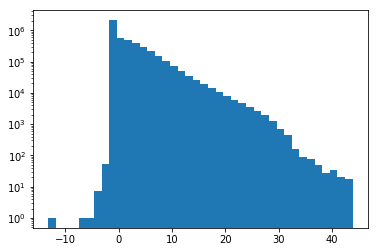

In [172]:
df['p20sum_lw_p/p'] = (df['p20sum_lw_p']-df['p20_pct'])/(np.maximum(df['p20_pct'],2))
df['p20sum_lw_p/p'].agg(['max','min','mean'])
df['p20sum_lw_p/p'].isnull().sum()
plt.hist(x=df['p20sum_lw_p/p'].fillna(1),bins=40,log=True)

In [173]:
for i in [0.001,0.01,0.1,0.2,0.5,0.8,0.9,0.99,0.999]:
    print(i,df['p20sum_lw_p'].quantile(i),df['p20sum_lw_p/p'].quantile(i))

0.001 -1.8491796851729227 -1.0211708240428825
0.01 -0.5438108149787574 -0.9990287810511135
0.1 -0.08204274984847297 -0.9915609376499875
0.2 -0.023237599838373563 -0.9825376423340013
0.5 0.04968303609624598 0.08053947017226964
0.8 0.28331902474775866 4.479302001156933
0.9 0.5592221879779202 7.261991772508057
0.99 2.5262079799835497 17.625765464283955
0.999 7.815963652551128 26.900519279098905


In [125]:
# df['p20sum_lw_p/p'] = a
# df[['p20sum_lw_p','p20_pct','p20sum_lw_p/p','r']].head(100)
mask_s = df['p20sum_lw_p/p']>4
mask_s.sum(),len(mask_s),mask_s.sum()/len(mask_s)

(375276, 4593560, 0.08169611368960022)

In [130]:
mask_date = df.index.get_level_values('date')>='2016-01-01'

base  = df.loc[mask_date,'r'].agg(agg_operations[:-1])
base
df.loc[mask_date,'r'].notnull().sum()

mean     -0.003319
median   -0.021764
max       5.543209
min      -0.972953
std       0.094291
Name: r, dtype: float64

3401059

In [187]:
mask_s = (df['p20sum_lw_p/p']>2.5 ) & (df['p20sum_lw_p']> 5) & (df['p20_pct']<15) & (df['p20_pct']>-7.5)# df['p20_pct'].abs()/4)# ((df['p20sum_lw_p']-df['p20_pct'])>df['p20_pct'].abs())
mask_s.sum()
df.loc[mask_date & mask_s,'r'].agg(agg_operations)
df.loc[mask_date & mask_s,'r'].reset_index('code').resample('Q').agg(agg_operations)

750

mean       -0.000726
median     -0.017544
max         0.413312
min        -0.105085
std         0.082722
size      203.000000
Name: r, dtype: float64

r                                             
                mean    median       max       min       std size
date                                                             
2016-03-31 -0.028735 -0.022098  0.016080 -0.098789  0.035617   16
2016-06-30  0.044996  0.044996  0.044996  0.044996       NaN    1
2016-09-30  0.042640 -0.032307  0.413312 -0.072574  0.167069   23
2016-12-31 -0.002305  0.000765  0.028769 -0.080439  0.023552   25
2017-03-31 -0.043191 -0.046536 -0.029412 -0.050279  0.009841    4
2017-06-30 -0.027936 -0.011544  0.022075 -0.084892  0.042868   11
2017-09-30 -0.025662 -0.013048  0.036875 -0.089137  0.038162   12
2017-12-31  0.013181 -0.014313  0.183287 -0.098096  0.087324   16
2018-03-31 -0.041009 -0.026549  0.000000 -0.105085  0.041061    5
2018-06-30       NaN       NaN       NaN       NaN       NaN    0
2018-09-30       NaN       NaN       NaN       NaN       NaN    0
2018-12-31       NaN       NaN       NaN       NaN       NaN    0
2019-03-31  0.019529  0.033580  0.072664 -0.066486  0.045037   11
2019-06-30 -0.045047 -0.047402  0.019706 -0.104363  0.024561   30
2019-09-30 -0.015274 -0.015274  0.018664 -0.049213  0.047996    2
2019-12-31  0.125888  0.125888  0.132386  0.119390  0.009189    2
2020-03-31  0.023903 -0.009248  0.296928 -0.090392  0.086964   44
2020-06-30 -0.010025 -0.010025 -0.010025 -0.010025       NaN    1

In [105]:
df.loc[mask_s,['close','p20sum_lw_p','p20_pct','p20sum_lw_p/p','r']].reset_index('code').sort_index().tail(50)

,code,close,p20sum_lw_p,p20_pct,p20sum_lw_p/p,r
date,,,,,,
2020-03-31,000063.SZ,675.683594,-1282.737961,-19.153755,-315.896051,-0.076191
2020-03-31,300059.SZ,620.476929,-384.458795,-13.008142,-92.862663,0.057644
2020-03-31,601318.SH,166.353836,-2286.798608,-12.982774,-568.453959,0.063020
2020-04-01,601318.SH,166.714600,-2707.390929,-13.973695,-673.354309,0.072345
2020-04-01,000063.SZ,654.844727,-1318.000699,-19.236761,-324.690984,-0.065285
2020-04-01,000100.SZ,13.520781,-426.211578,-29.516125,-99.173863,-0.006849
2020-04-01,600030.SH,121.152199,-712.863776,-12.751675,-175.028025,0.047230
2020-04-01,000725.SZ,18.468000,-795.971889,-24.302786,-192.917276,0.015958
2020-04-01,300059.SZ,621.250122,-728.641847,-16.821945,-177.954975,0.049751


In [107]:
mask_s = (df['p20sum_lw_p/p']>10 )  & (df['p20sum_lw_p']>df['p20_pct'].abs()) 
mask_s.sum()
df.loc[mask_s,'r'].agg(agg_operations)
df.loc[mask_s,'r'].reset_index('code').resample('Q').agg(agg_operations)
df.loc[mask_s,['close','p20sum_lw_p','p20_pct','p20sum_lw_p/p','r']].reset_index('code').sort_index().tail(120)

22544

mean         -0.005073
median       -0.025514
max           1.314909
min          -0.556287
std           0.103748
size      22544.000000
Name: r, dtype: float64

r                                              
                mean    median       max       min       std  size
date                                                              
2014-03-31 -0.011829 -0.008197  0.033578 -0.078110  0.037517     9
2014-06-30 -0.009830 -0.008044  0.027930 -0.055839  0.021137    70
2014-09-30 -0.010019 -0.018132  0.193676 -0.081081  0.042664   165
2014-12-31  0.069146  0.016992  1.151947 -0.129091  0.177772   819
2015-03-31  0.024045 -0.026671  1.314909 -0.206311  0.164609  1819
2015-06-30 -0.013101 -0.033293  0.626582 -0.381737  0.097385  4716
2015-09-30 -0.051024 -0.052365  0.646174 -0.400300  0.092442  2211
2015-12-31 -0.021207 -0.029823  0.262023 -0.179400  0.059385  1149
2016-03-31 -0.018141 -0.020690  0.263158 -0.343980  0.068516   265
2016-06-30 -0.012646 -0.018951  0.170624 -0.186603  0.060024   276
2016-09-30 -0.013685 -0.022461  0.456496 -0.114945  0.059307   424
2016-12-31 -0.010445 -0.021822  0.222539 -0.142333  0.053947   598
2017-03-31  0.009211 -0.002442  0.335835 -0.125161  0.056512   438
2017-06-30  0.033478  0.002060  0.519189 -0.171053  0.109583   688
2017-09-30  0.021891 -0.014015  0.595908 -0.303069  0.116499   870
2017-12-31  0.019125 -0.012792  0.324841 -0.158301  0.082501   993
2018-03-31 -0.032676 -0.039823  0.163772 -0.556287  0.057474   936
2018-06-30 -0.029568 -0.038898  0.169143 -0.553642  0.067582   418
2018-09-30 -0.028241 -0.045024  0.326717 -0.153546  0.067820   235
2018-12-31 -0.024388 -0.038046  0.239799 -0.119871  0.060146   216
2019-03-31  0.065856  0.017300  0.701577 -0.110806  0.133227   698
2019-06-30 -0.020015 -0.029974  0.285714 -0.372999  0.060334   905
2019-09-30 -0.007401 -0.026882  0.382807 -0.115328  0.068495   719
2019-12-31  0.009304 -0.006762  0.377410 -0.191919  0.079146   737
2020-03-31 -0.018564 -0.034810  0.586043 -0.203804  0.091768  1568
2020-06-30 -0.006627 -0.016922  0.253326 -0.094103  0.054132   602

,code,close,p20sum_lw_p,p20_pct,p20sum_lw_p/p,r
date,,,,,,
2020-05-20,002185.SZ,141.353455,162.582452,10.202419,14.935676,NaN
2020-05-20,000651.SZ,8948.468750,353.237823,4.899442,71.097559,NaN
2020-05-20,600036.SH,170.244125,85.925924,5.538654,14.513863,-0.046119
2020-05-20,603986.SH,857.756958,164.452072,12.913871,11.734530,-0.075046
2020-05-20,601318.SH,178.581589,207.626350,2.561188,51.266290,NaN
2020-05-20,600547.SH,600.722961,77.498461,6.083119,11.739922,-0.044713
2020-05-20,000100.SZ,16.341721,168.105635,14.571476,10.536624,-0.057915
2020-05-20,002475.SZ,1196.238159,211.134313,9.788549,20.569520,-0.032195
2020-05-20,000063.SZ,638.584167,202.924930,1.125002,50.449982,-0.066339


In [ ]:
import ml_model
ml_model.assess_feature(df['p20sum_lw_p/p'],df['r'])